In [66]:
import os

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# Experimental file to compare results on GHGEmissions using standard scaled data, and using data transformed with the Box Cox method

- Same index will be used for splits

In [67]:
file_bcx = "./data/data_bcx.csv"
file_std = "./data/seattle_predict_ghg_eui.csv"

df_bcx = pd.read_csv(file_bcx)
df_bcx.set_index("OSEBuildingID", inplace=True)
df_std = pd.read_csv(file_std)
df_std.set_index("OSEBuildingID", inplace=True)


In [68]:
target = "target_GHGEmissionsIntensity(kgCO2e/ft2)"

In [69]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist_bcx = [
    "bcx_GHGEmissionsIntensity(kgCO2e/ft2)", # Transformed target
    "target_SourceEUI(kWh/m2)", # not to scale
    ]

df_bcx.drop(columns=droplist_bcx, inplace=True)


In [70]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist_std = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    ]

df_std.drop(columns=droplist_std, inplace=True)


In [94]:
std_reg = Linear_reg(dataframe=df_std, target=target)


In [95]:
# Let's see if the split if any good : 

alphas_ridge = np.arange(0.1, 45, 0.5)
alphas_elnet = np.arange(0.1, 45, 0.5)
alphas_lasso = np.arange(0.01, 15, 0.04)

std_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


Ridge: 

Ridge best Alpha : 7.6
Time used during fit = 0.021938582882285118
Time used during predict = 4.26657497882843e-05


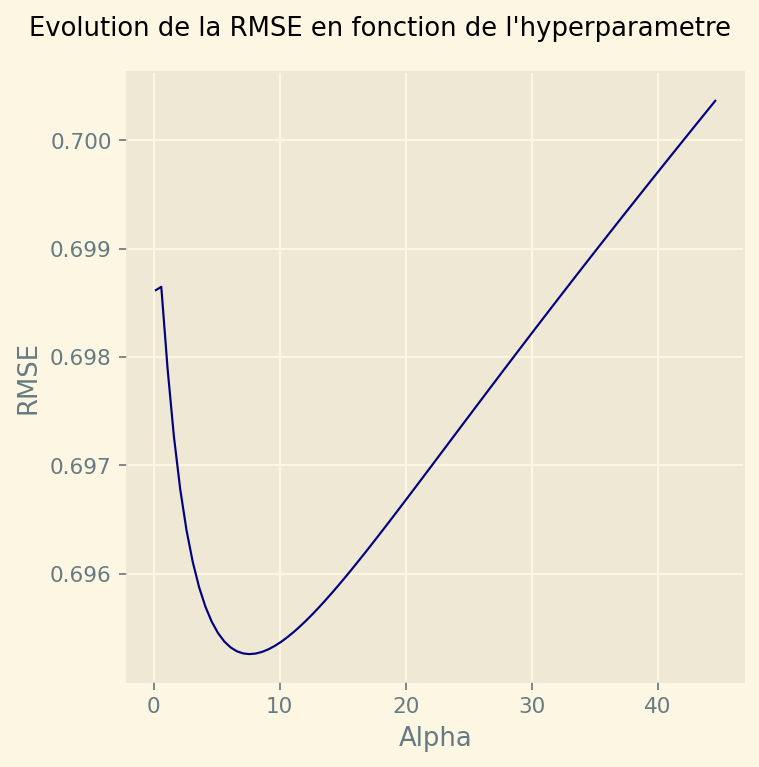

In [107]:
print("Ridge: \n")
print(f"Ridge best Alpha : {std_reg.ridge_cv.alpha_}")
print(f"Time used during fit = {std_reg.ridge_time_card.t_fit}")
print(f"Time used during predict = {std_reg.ridge_time_card.t_predict}")

std_reg.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.23496200004592538
Time used during predict = 7.183384150266647e-05


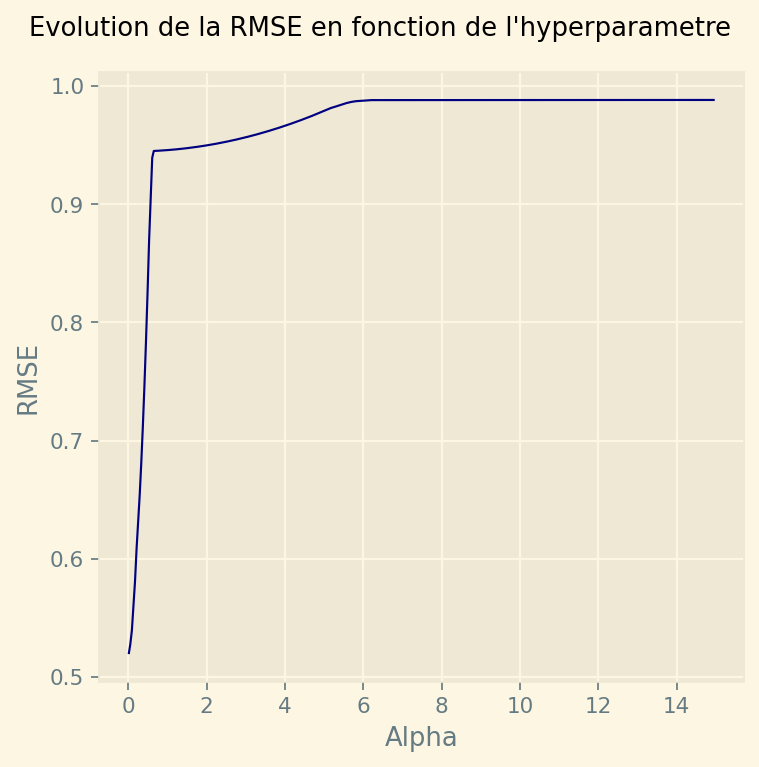

In [108]:
print("LASSO: \n")
print(f"LASSO best Alpha : {std_reg.lasso_cv.alpha_}")
print(f"Time used during fit = {std_reg.lasso_time_card.t_fit}")
print(f"Time used during predict = {std_reg.lasso_time_card.t_predict}")

std_reg.lasso_plot()


In [110]:
# Yup me like, lets get the indexes : 

ids_train, ids_test = freeze_model(model=std_reg)


In [111]:
bcx_reg = Linear_reg(dataframe=df_bcx, target=target)

bcx_train = df_bcx[df_bcx.index.isin(ids_train)]
bcx_test = df_bcx[df_bcx.index.isin(ids_test)]

# Checking : 

for idx in bcx_train.index:
    if idx not in std_reg.df_train.index:
        print("oops")
    
print("train checked")

for idx in bcx_test.index:
    if idx not in std_reg.df_test.index:
        print("oops")

print("test checked")
    

train checked
test checked


In [100]:
bcx_reg.force_split(df_train_ovr=bcx_train, df_test_ovr=bcx_test)


In [101]:
bcx_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


Ridge: 

Ridge best Alpha : 3.6
Time used during fit = 0.021553041879087687
Time used during predict = 4.0874816477298737e-05


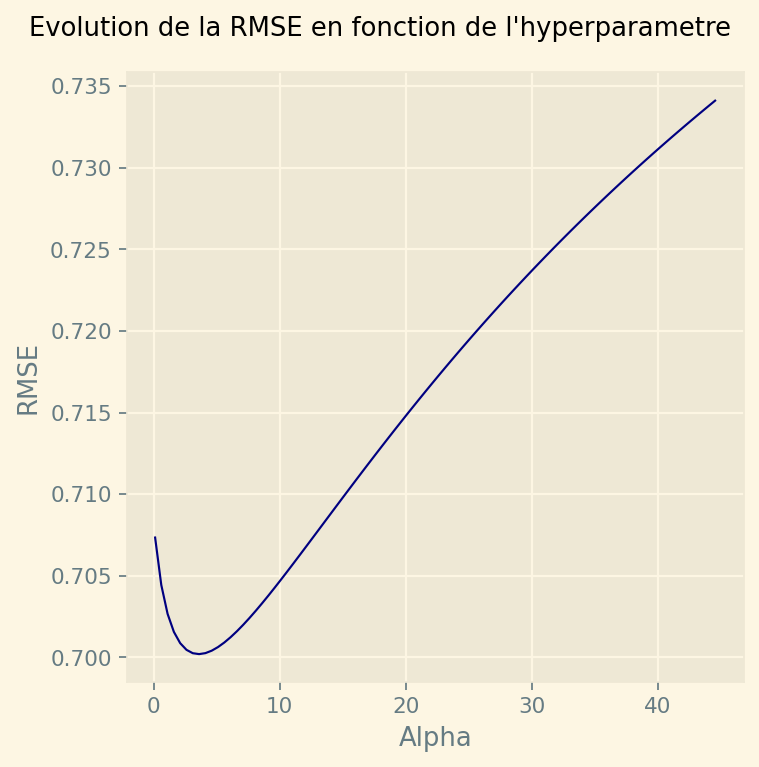

In [102]:
print("Ridge: \n")
print(f"Ridge best Alpha : {bcx_reg.ridge_cv.alpha_}")
print(f"Time used during fit = {bcx_reg.ridge_time_card.t_fit}")
print(f"Time used during predict = {bcx_reg.ridge_time_card.t_predict}")

bcx_reg.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.18446391681209207
Time used during predict = 0.00030945800244808197


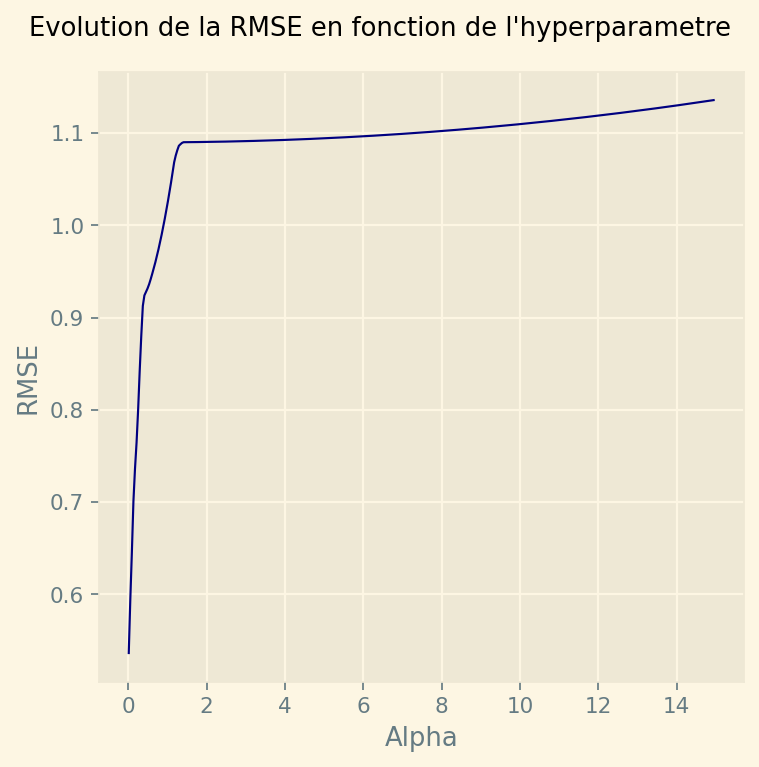

In [103]:
print("LASSO: \n")
print(f"LASSO best Alpha : {bcx_reg.lasso_cv.alpha_}")
print(f"Time used during fit = {bcx_reg.lasso_time_card.t_fit}")
print(f"Time used during predict = {bcx_reg.lasso_time_card.t_predict}")

bcx_reg.lasso_plot()


In [104]:
# Similar behaviour at different values, lets check metrics :

std_reg.format_all_metrics()


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.715718,0.449811,0.695258,0.605445,0.720594,0.579547,0.947175,0.571798
Test,0.690249,0.597790,0.686365,0.602304,0.715056,0.568361,0.716052,0.567157


In [105]:
bcx_reg.format_all_metrics()

,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.725628,0.418021,0.700199,0.591651,0.731535,0.560045,0.988815,0.531137
Test,0.802048,0.456948,0.797061,0.463679,0.805456,0.452322,0.789735,0.473494


In [ ]:
# OK so bcx is worse overall, nice, lets check with cv=Rkfolds

k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
bcx_reg.common_parameters["cv"] = k_folds
std_reg.common_parameters["cv"] = k_folds


In [ ]:
bcx_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )

std_reg.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)

In [ ]:
bcx_reg.format_all_metrics()


In [ ]:
std_reg.format_all_metrics()


In [112]:
# Still worse, ok nice, lets forget about Box Cox
